# Mushroom classification by pre-trained neural networks

The project uses the mushroom images' dataset uploaded from the Kaggle website (https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images). The dataset contains 6714 images of mushrooms. The dataset is divided into 9 folders, each of them containing images of mushrooms of a separate class. There are nine classes of mushrooms in the dataset in total: Agaricus, Amanita, Boletus, Cortinarius, Entoloma, Hygrocybe, Lactarius, Russula, Suillus. 

The purpose of the project is to apply transfer learning for training classifiers which would be able to corectly classify mushrooms - that is, to provide labels to images of various mushrooms, coresponding to their actual classes. 

The project consists of two parts: 1) the exploratory analysis of the dataset of mushroom images and 2) building, training, fine-tuning and evaluating classifiers able to predict mushroom classes. 

### Importing libraries

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib and seaborn will be used for data visualization. Various modules of the torch library as well as pytorch-lightning and fastai libraries will be used for data loading, importing pretrained models, training, summarizing and fine-tuning. Sklearn metrics will be used for presenting confusion matrix and classification report. 

In [107]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.utils.data as data, torchvision as tv
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.io import read_image
from torchvision import models
from torchvision.models import resnet50, resnet152, resnet18, ResNet50_Weights
from torchvision.datasets import ImageFolder

from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split, WeightedRandomSampler
from torchsummary import summary

import pytorch_lightning as pl

import os
import random
import shutil

from fastai.vision.all import *

from skimage import io, transform
from itertools import chain 
import sklearn.metrics as metrics

from importlib import reload
from sklearn.metrics import confusion_matrix, classification_report

import time
from collections import Counter
from scipy import stats
import cv2
import requests
from PIL import Image
from PIL import ImageFile
from io import BytesIO

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [135]:
!pipreqs --force /Users/user/PycharmProjects/ComputerVision

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /Users/user/PycharmProjects/ComputerVision/requirements.txt


### Importing data

The transformed data (resized, normalized, transformed to tensors) are imported from the files of the local directory containing subfolders with mushroom images by using the ImageFolder function. The environment function LOAD_TRUNCATED_IMAGES is set to True in order to avoid errors while loading images.

In [108]:
data_dir = '/Users/user/PycharmProjects/ComputerVision/Mushrooms/Mushrooms/'

In [109]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [131]:
transform1 = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [132]:
dataset = ImageFolder(root=data_dir, transform=transform1)

A list with names of mushroom classes and the function to label numerical values with names of mushroom classes are created.

In [112]:
label_names = ['Agaricus','Amanita','Boletus','Cortinarius','Entoloma','Hygrocybe','Lactarius','Russula','Suillus']

In [113]:
def output_label(label):
    output_mapping = {
                 0: label_names[0],
                 1: label_names[1],
                 2: label_names[2],
                 3: label_names[3],
                 4: label_names[4], 
                 5: label_names[5], 
                 6:label_names[6],
                 7: label_names[7],
                 8: label_names[8],
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

## 1. Exploratory analysis

The exploratory analysis of the mushroom image dataset includes examination of width, height, numbers of pixels, modes of channels of images. The dataframe with the data on various parameters of images is created by looping over images in the mushroom directory. Images are opened by the Image module in the pillow library and their size and mode data are extracted and saved in a dictionary. 

Also, random images from various classes and analysis of the distribution of the target variable which values are numerical code values for names of mushroom classes. 

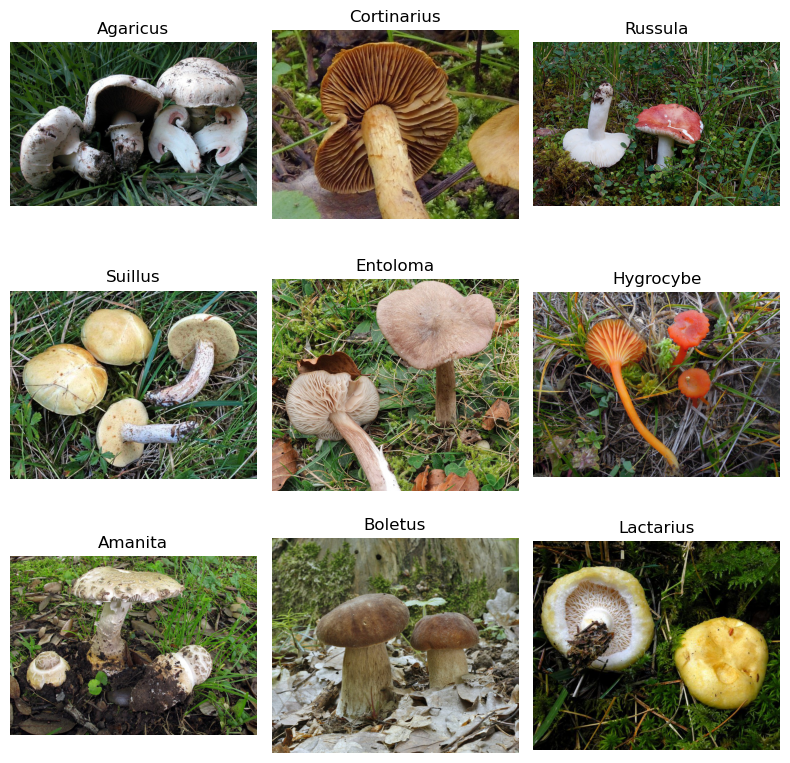

In [114]:
class_folders = os.listdir(data_dir)
class_folders.remove('.DS_Store')
num_images_per_class = 1
images_dict = {}
images_dict['img_path']=[]
images_dict["img_height"] = []
images_dict["img_width"] = []
images_dict["img_num_pixels"] = []
images_dict["img_num_channels"] = []
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, class_name in enumerate(class_folders):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    for image in images: 
        img = Image.open(class_path+'/'+image)
        width, height = img.size
        img_num_pixels = width * height
        num_channels = img.mode
        images_dict["img_path"].append(image)
        images_dict["img_height"].append(height)
        images_dict["img_width"].append(width)
        images_dict["img_num_pixels"].append(img_num_pixels)
        images_dict["img_num_channels"].append(num_channels)
    if images:
        random_image = random.choice(images)
        image_path = os.path.join(class_path, random_image)
        img = Image.open(image_path)
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title(class_name)
        axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show();
 

The dictionary is transformed into a dataframe (see bellow).

In [115]:
images_df = pd.DataFrame(images_dict)
images_df.head()

,img_path,img_height,img_width,img_num_pixels,img_num_channels
0,251_J9uSJkkBULQ.jpg,531,800,424800,RGB
1,357__w_XUQZMZEw.jpg,600,800,480000,RGB
2,374_Xap1L15Z8BM.jpg,600,777,466200,RGB
3,442_bdfUNhioT1A.jpg,600,800,480000,RGB
4,092_YzaMvFvqkiM.jpg,575,800,460000,RGB


In [116]:
images_df.describe()

,img_height,img_width,img_num_pixels
count,6714.000000,6714.000000,6.714000e+03
mean,579.812332,796.176795,4.720923e+05
std,100.118028,132.803124,1.647286e+05
min,152.000000,259.000000,5.022000e+04
25%,533.000000,800.000000,4.224000e+05
50%,580.000000,800.000000,4.456000e+05
75%,600.000000,800.000000,4.800000e+05
max,1024.000000,1280.000000,1.303552e+06


In [117]:
for column, values in images_df.iloc[:,1:4].iteritems():
    stat, p = stats.shapiro(values)
    print(f'{column}')
    print(f'Shapiro Wilk test statistics: {stat}')
    print(f'p-value: {p}')
    if p > 0.05:
        print("The data appears to be normally distributed (fail to reject null hypothesis).")
    else:
        print("The data does not appear to be normally distributed (reject null hypothesis).")
    print('')

img_height
Shapiro Wilk test statistics: 0.859581470489502
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).

img_width
Shapiro Wilk test statistics: 0.7487140893936157
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).

img_num_pixels
Shapiro Wilk test statistics: 0.7264012098312378
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).



In [118]:
images_df.iloc[:,1:4].columns

Index(['img_height', 'img_width', 'img_num_pixels'], dtype='object')

In [119]:
if p > 0.05:
    print("The data appears to be normally distributed (fail to reject null hypothesis).")
else:
    print("The data does not appear to be normally distributed (reject null hypothesis).")

The data does not appear to be normally distributed (reject null hypothesis).


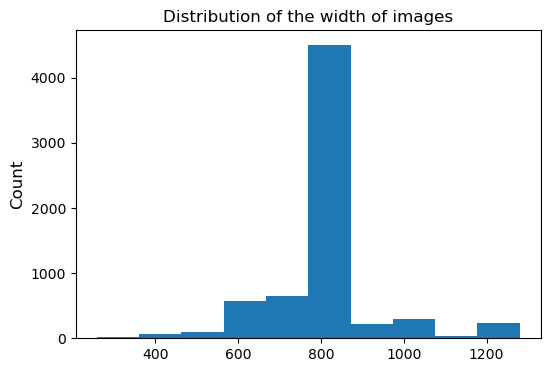

In [120]:
ax = images_df["img_width"].plot(kind="hist", figsize=(6,4))
plt.title("Distribution of the width of images", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show();

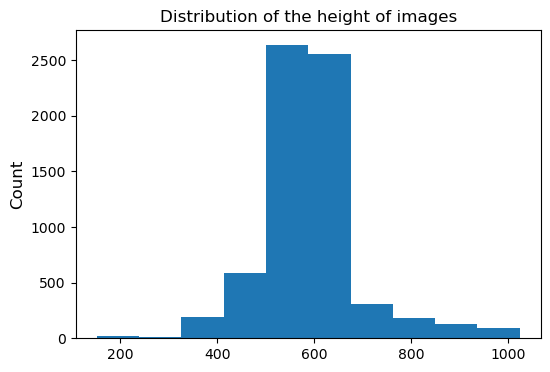

In [121]:
ax = images_df["img_height"].plot(kind="hist", figsize=(6,4))
plt.title("Distribution of the height of images", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show();

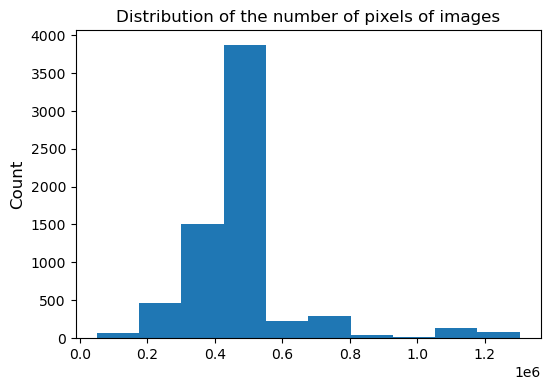

In [122]:
ax = images_df["img_num_pixels"].plot(kind="hist", figsize=(6,4))
plt.title("Distribution of the number of pixels of images", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show();

In [123]:
images_df["img_num_channels"].value_counts()

RGB    6712
L         2
Name: img_num_channels, dtype: int64

It can be observed from the examination of the descriptive statistics that images in the mushroom dataset are not of the same size. As it seen from the results of the Shapiro Wilk test, widths, hights, and numbers of pixels are not normally distrubuted (p values are lower than 0.05). Their heights and width vary from the smallest (152 height and 256 width respectively) and largest (1024 heigth and 1280 width respectively). The average height and width are 579 and 796 respectively. The average size of pixels is 470000. The majority of images are colourful (RGB channel), only two images are greyscale.





#### Plotting the distribution of mushroom classes

In [124]:
classes = [output_label(label) for _, label in dataset]
class_count = Counter(classes)
class_count = pd.Series(class_count).sort_values(ascending=False)

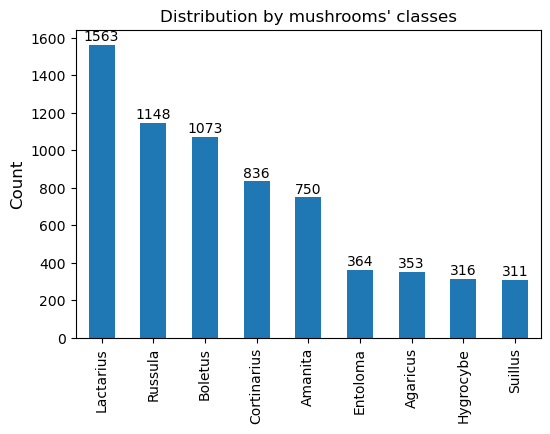

In [125]:
ax = class_count.plot(kind="bar", figsize=(6,4))
plt.title("Distribution by mushrooms' classes", fontsize=12)
plt.ylabel("Count", fontsize=12)

for i, count in enumerate(class_count):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

The distribution of categorical variable 'classes' with labels for names of mushroom classes as its values is plotted with the barplot (images of each class are counted with the Counter module). It can be observed that the variable is imbalanced with such classes as Lactarius, Russula, and Boletus having more than 1000 images and such classes as Entoloma, Agaricus, Hygrocebe, and Suillus having less than 400 images. 

## 2. Modelling

### Splitting the dataset into train, validation and test datasets

In [126]:
def set_weights(dataset):
    train_classes = [label for _, label in dataset]
    class_count = Counter(train_classes)
    class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
    sample_weights = [0] * len(dataset)
    for idx, (image, label) in enumerate(dataset):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(dataset), replacement=True)
    return sampler

In [127]:
batch_size = 32
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [128]:
sampler = set_weights(train_dataset)

### Creating classes for transfer learning based on pre-trained models

In [56]:
def create_lightning_module(model, num_classes, opt, learning_rate):
    class ResnetLightening(pl.LightningModule):
        def __init__(self, num_classes):
            super().__init__()
            self.resnet = torch.hub.load('pytorch/vision', model, pretrained=True)
            for param in self.resnet.parameters():
                param.requires_grad = False
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, num_classes)

        def forward(self, x):
            return self.resnet(x)

        def training_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            loss = F.cross_entropy(y_hat, y)
            return loss

        def validation_step(self, batch, batch_idx):
            loss, acc = self._shared_eval_step(batch, batch_idx)
            metrics = {"val_acc": acc, "val_loss": loss}
            self.log_dict(metrics)
            return metrics

        def test_step(self, batch, batch_idx):
            loss, acc = self._shared_eval_step(batch, batch_idx)
            metrics = {"test_acc": acc, "test_loss": loss}
            self.log_dict(metrics)
            return metrics
        
        def predict_step(self, batch, batch_idx):
            y_hat = self.forward(x)
            return y_hat
        
        def _shared_eval_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            loss = F.cross_entropy(y_hat, y)
            acc = accuracy(y_hat, y)
            return loss, acc

        def configure_optimizers(self):
            if opt == 'Adam':
                optimizer = optim.Adam(self.resnet.parameters(), lr=learning_rate)
            elif opt == 'SGD':
                optimizer = optim.SGD(self.resnet.parameters(), lr=learning_rate)
            return optimizer

        def train_dataloader(self):
            return DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, sampler=sampler)

        def val_dataloader(self):
            return DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

        def test_dataloader(self):
            return DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)
    
    return ResnetLightening(num_classes = num_classes)
    

### Creating instances of the classes for transfer learning

In [19]:
model18 = create_lightning_module(model = 'resnet18', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [20]:
model50 = create_lightning_module(model = 'resnet50', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [21]:
model152 = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [22]:
model152_SGD = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'SGD', learning_rate = 0.001)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [23]:
model152_01 = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.01)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [24]:
model_list = [model18, model50, model152, model152_SGD, model152_01]
model_name_list = ['model18', 'model50', 'model152', 'model152_SGD', 'model152_01']

### Summarizing model parameters

In [25]:
for model, model_name in zip(model_list, model_name_list):
    print(f'{model_name}')
    print(f'{summary(model, (3, 256, 256))}')
    print('')


model18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

### Attaching the models to the GPU of the Mac computer

In [26]:
device = torch.device("mps")
for model in model_list:
    model.to(device)


### Training the models

In [70]:
metrics_df = {}
metrics_df["model_name"] = []
metrics_df["train_time"] = []
metrics_df["prediction_time"]=[]
metrics_df["val_accuracy"]=[]
metrics_df["val_loss"]=[]
metrics_df["test_accuracy"]=[]
metrics_df["test_loss"]=[]
trainer_list = []

In [23]:
for model, model_name in zip(model_list, model_name_list):

    start_time = time.time()
    trainer = pl.Trainer(max_epochs = 10)
    trainer.fit(model)
    trainer_list.append(trainer)

    end_time = time.time()
    exec_time = end_time - start_time
    print('')
    print(f'{model_name}')
    print(f'Execution time: {exec_time}')
    metrics_df["model_name"].append(model_name)
    metrics_df["train_time"].append(exec_time)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.2 M
----------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 23.5 M
----------------------------------
18.4 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)



model18
Execution time: 349.6345751285553


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 58.2 M
----------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)



model50
Execution time: 637.0125670433044


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 58.2 M
----------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)



model152
Execution time: 1437.972265958786


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 58.2 M
----------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)



model152_SGD
Execution time: 1455.1923789978027


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



model152_01
Execution time: 1434.0028381347656


### Saving the models to the local files

In [24]:
for trainer, model_name in zip(trainer_list, model_name_list):

    checkpoint_path = f'mushroom_classifier_{model_name}.ckpt'
    trainer.save_checkpoint(checkpoint_path)


### Assessing the performance of the models on the validation and test datasets

In [25]:
for trainer, model_name in zip(trainer_list, model_name_list):
    print(f'{model_name}')
    metric = trainer.validate()
    metrics_df['val_accuracy'].append(metric[0]["val_acc"])
    metrics_df['val_loss'].append(metric[0]["val_loss"])
    print('')

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_41/checkpoints/epoch=9-step=1260.ckpt


model18


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_41/checkpoints/epoch=9-step=1260.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.692995548248291     │
│         val_loss          │    0.8940877318382263     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_42/checkpoints/epoch=9-step=1260.ckpt



model50


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_42/checkpoints/epoch=9-step=1260.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7257823944091797     │
│         val_loss          │     0.822005569934845     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_43/checkpoints/epoch=9-step=1260.ckpt



model152


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_43/checkpoints/epoch=9-step=1260.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7168405652046204     │
│         val_loss          │    0.8237408399581909     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_44/checkpoints/epoch=9-step=1260.ckpt



model152_SGD


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_44/checkpoints/epoch=9-step=1260.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7228018045425415     │
│         val_loss          │    0.7946895360946655     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_45/checkpoints/epoch=9-step=1260.ckpt



model152_01


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_45/checkpoints/epoch=9-step=1260.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6780924201011658     │
│         val_loss          │    1.5327739715576172     │
└───────────────────────────┴───────────────────────────┘

In [26]:
for trainer, model_name in zip(trainer_list, model_name_list):
    print(f'{model_name}')
    metric = trainer.test()
    metrics_df['test_accuracy'].append(metric[0]["test_acc"])
    metrics_df['test_loss'].append(metric[0]["test_loss"])
    print('')

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_41/checkpoints/epoch=9-step=1260.ckpt
Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_41/checkpoints/epoch=9-step=1260.ckpt


model18


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6845238208770752     │
│         test_loss         │    0.8872391581535339     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_42/checkpoints/epoch=9-step=1260.ckpt



model50


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_42/checkpoints/epoch=9-step=1260.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.726934552192688     │
│         test_loss         │    0.7621033191680908     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_43/checkpoints/epoch=9-step=1260.ckpt



model152


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_43/checkpoints/epoch=9-step=1260.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7336309552192688     │
│         test_loss         │    0.7743849158287048     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_44/checkpoints/epoch=9-step=1260.ckpt



model152_SGD


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_44/checkpoints/epoch=9-step=1260.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7410714030265808     │
│         test_loss         │     0.722130298614502     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_45/checkpoints/epoch=9-step=1260.ckpt



model152_01


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_45/checkpoints/epoch=9-step=1260.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6964285969734192     │
│         test_loss         │    1.2977739572525024     │
└───────────────────────────┴───────────────────────────┘

In [27]:
for model in model_list:
    model = model.eval()


### Generating predictions on the models

In [34]:
predictions_list = []
y_true_list = []
for model, model_name in zip(model_list, model_name_list):
    predictions_ = []
    y_true_ = []
    start_time= time.time()
    with torch.no_grad():
        for data, labels in DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6):
            y_proba = nn.functional.softmax(model.forward(data), dim=1)
            y_hat = torch.argmax(y_proba, axis=1)
            predictions_.append(y_hat)
            y_true_.append(labels)
    predictions_list.append(predictions_)
    y_true_list.append(y_true_)
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f'{model_name}')
    print(f'Prediction time:{prediction_time}')
    metrics_df["prediction_time"].append(prediction_time)

model18
Prediction time:52.267045974731445
model50
Prediction time:174.1132788658142
model152
Prediction time:419.4108672142029
model152_SGD
Prediction time:430.32041692733765
model152_01
Prediction time:435.0403938293457


### Loading models from a local directory and generating predictions on them

In [60]:
checkpoint_path_list = []
for model_name in model_name_list:
    checkpoint_path = f'mushroom_classifier_{model_name}.ckpt'
    checkpoint_path_list.append(checkpoint_path)
 

In [63]:
model18_load = create_lightning_module(model = 'resnet18', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001).load_from_checkpoint(checkpoint_path_list[0], 
                                                                                      num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [64]:
model50_load = create_lightning_module(model = 'resnet50', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001).load_from_checkpoint(checkpoint_path_list[1],
                                                                                       num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [65]:
model152_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001).load_from_checkpoint(checkpoint_path_list[2],
                                                                                         num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [66]:
model152_SGD_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'SGD', learning_rate = 0.001).load_from_checkpoint(checkpoint_path_list[3],
                                                                                        num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [67]:
model152_01_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.01).load_from_checkpoint(checkpoint_path_list[4],
                                                                                        num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [68]:
load_model_list = [model18_load, model50_load, model152_load, model152_SGD_load, model152_01_load]
load_model_name_list = ['model18_load', 'model50_load', 'model152_load', 'model152_SGD_load', 'model152_01_load']

In [71]:
predictions_list = []
y_true_list = []
for model, model_name in zip(load_model_list, load_model_name_list):
    predictions_ = []
    y_true_ = []
    start_time= time.time()
    with torch.no_grad():
        for data, labels in DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6):
            y_proba = nn.functional.softmax(model.forward(data), dim=1)
            y_hat = torch.argmax(y_proba, axis=1)
            predictions_.append(y_hat)
            y_true_.append(labels)
    predictions_list.append(predictions_)
    y_true_list.append(y_true_)
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f'{model_name}')
    print(f'Prediction time:{prediction_time}')
    metrics_df["prediction_time"].append(prediction_time)

model18_load
Prediction time:51.32893776893616
model50_load
Prediction time:168.0800120830536
model152_load
Prediction time:362.80513095855713
model152_SGD_load
Prediction time:389.03737926483154
model152_01_load
Prediction time:14289.176522016525


In [58]:
model.eval()
trainer = pl.Trainer()
predictions = trainer.predict(model, 
    dataloaders=DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

TypeError: create_lightning_module.<locals>.ResnetLightening.predict_step() takes 2 positional arguments but 3 were given

In [35]:
ytrue_list = []
pred_list = []
for predictions_ in predictions_list:
    predictions = torch.stack(predictions_[:-1]).view(-1)
    pred_list.append(predictions)

for y_true_ in y_true_list:   
    y_true = torch.stack(y_true_[:-1]).view(-1)
    ytrue_list.append(y_true)

### Comparing and visualizing metrics of the models

In [38]:
for pred, ytrue, model_name in zip(pred_list, ytrue_list, model_name_list):
    print(f'{model_name}')
    classification_report = classification_report(ytrue, pred)
    print(classification_report)
    print('')

model18


TypeError: 'str' object is not callable

In [252]:
#reload(metrics)
classification_report = classification_report(ytrue_list[0], pred_list[0], target_names = label_names)
print(classification_report)

TypeError: 'str' object is not callable

In [236]:
conf_mat_list = []
for pred, ytrue in zip(pred_list, ytrue_list):
    conf_mat = confusion_matrix(ytrue, pred)
    conf_mat_list.append(conf_mat)


In [232]:
def plot_confusion_matrix(conf_matrix, figsize, model_name):
    plt.figure(figsize=figsize)
    sns.heatmap(pd.DataFrame(np.round(conf_matrix, 2)), annot=True, fmt='g',  
                xticklabels=label_names, yticklabels=label_names)
    plt.title (f"Confusion matrix of the classifier trained on {model_name}")
    plt.show();

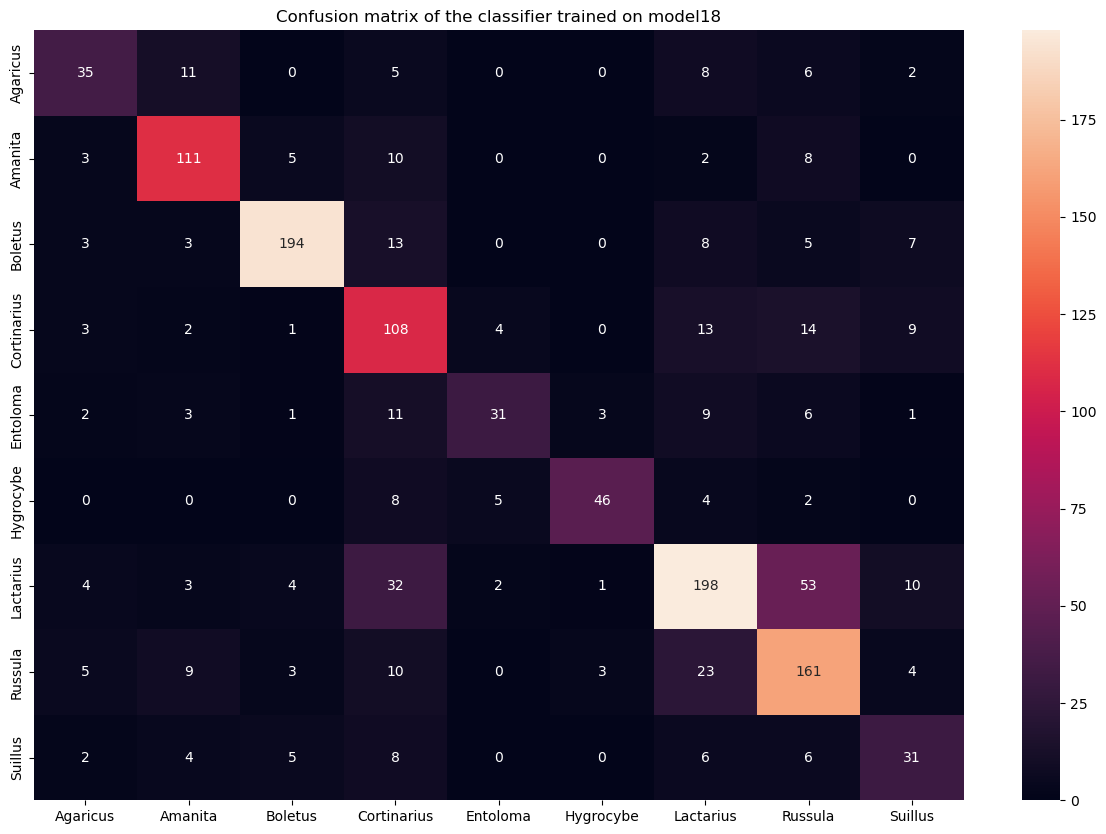

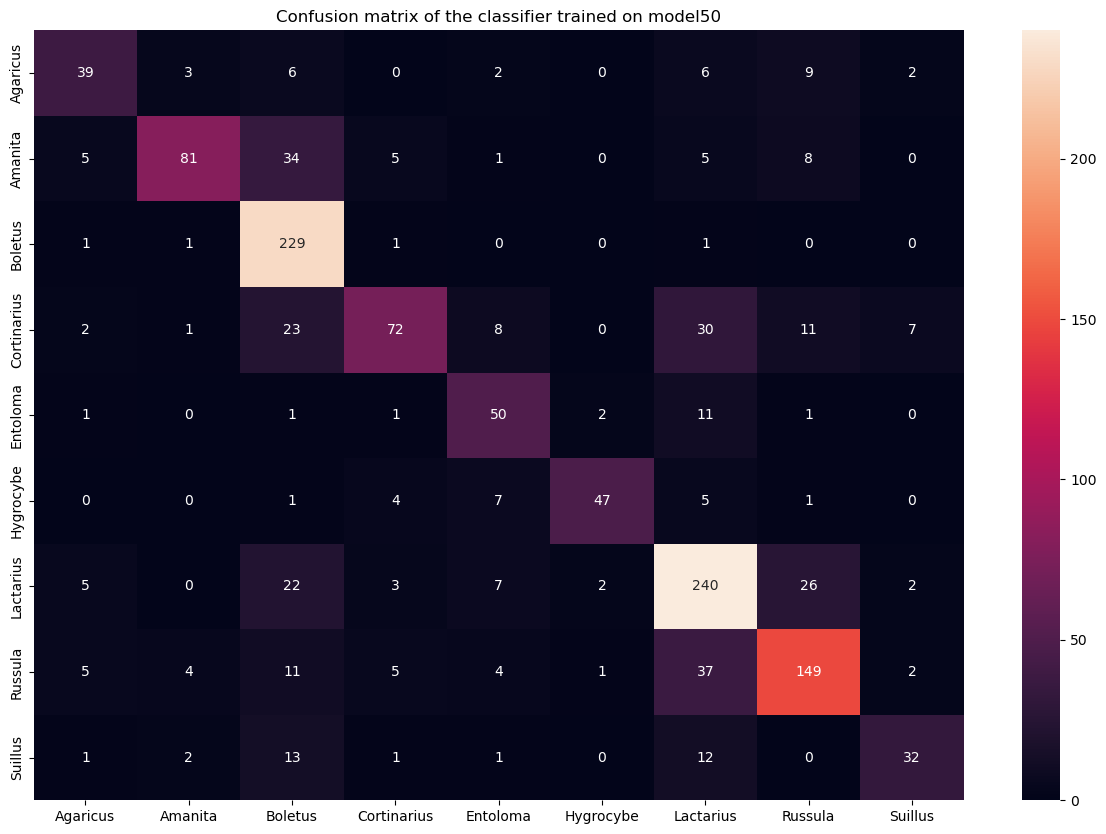

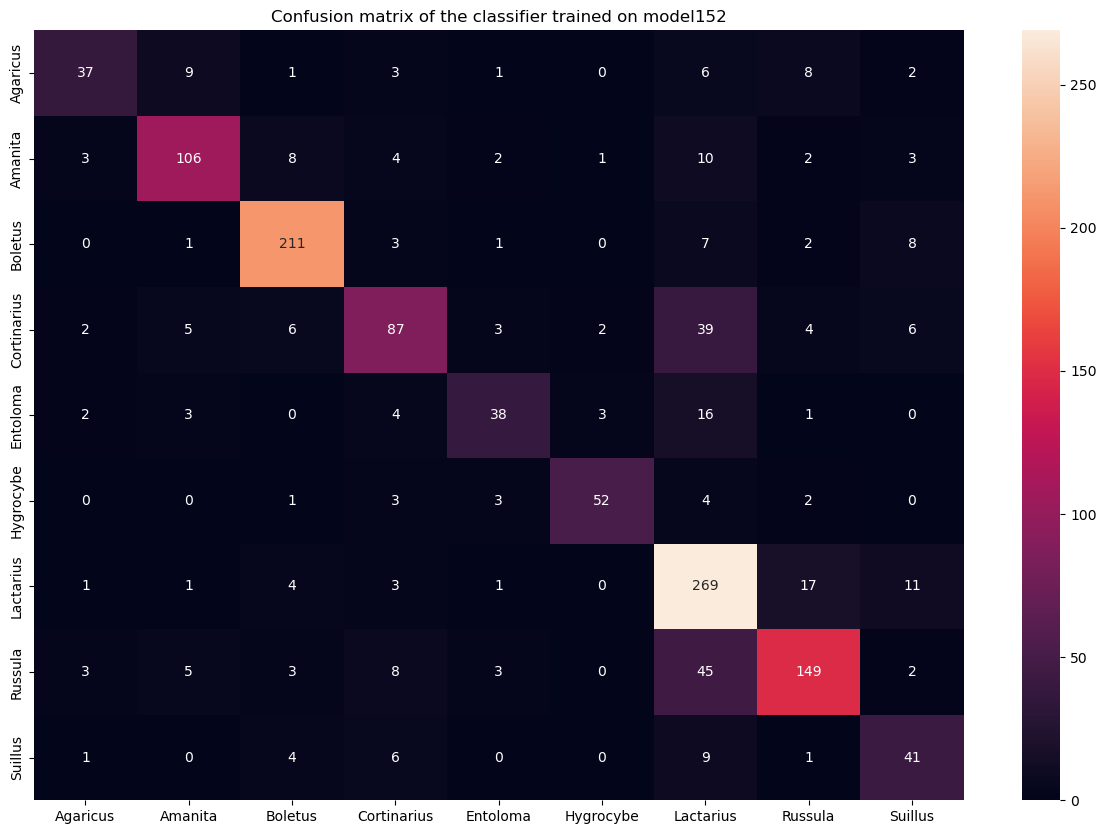

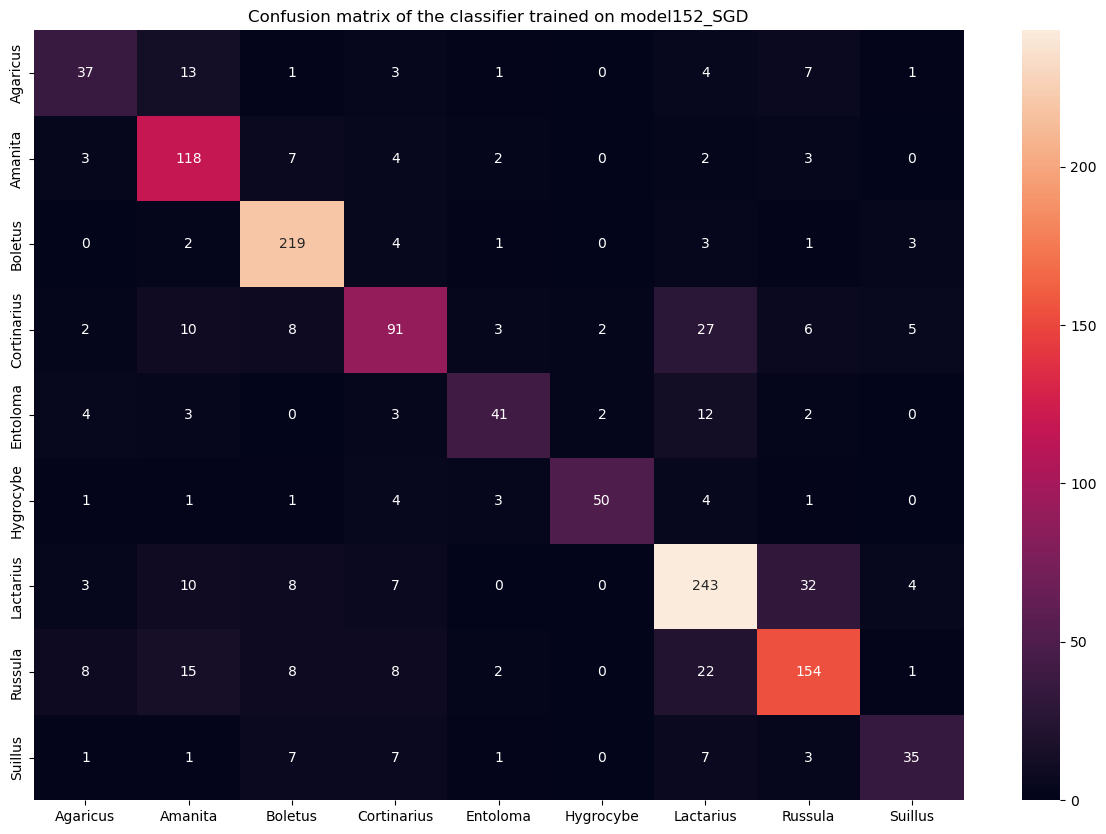

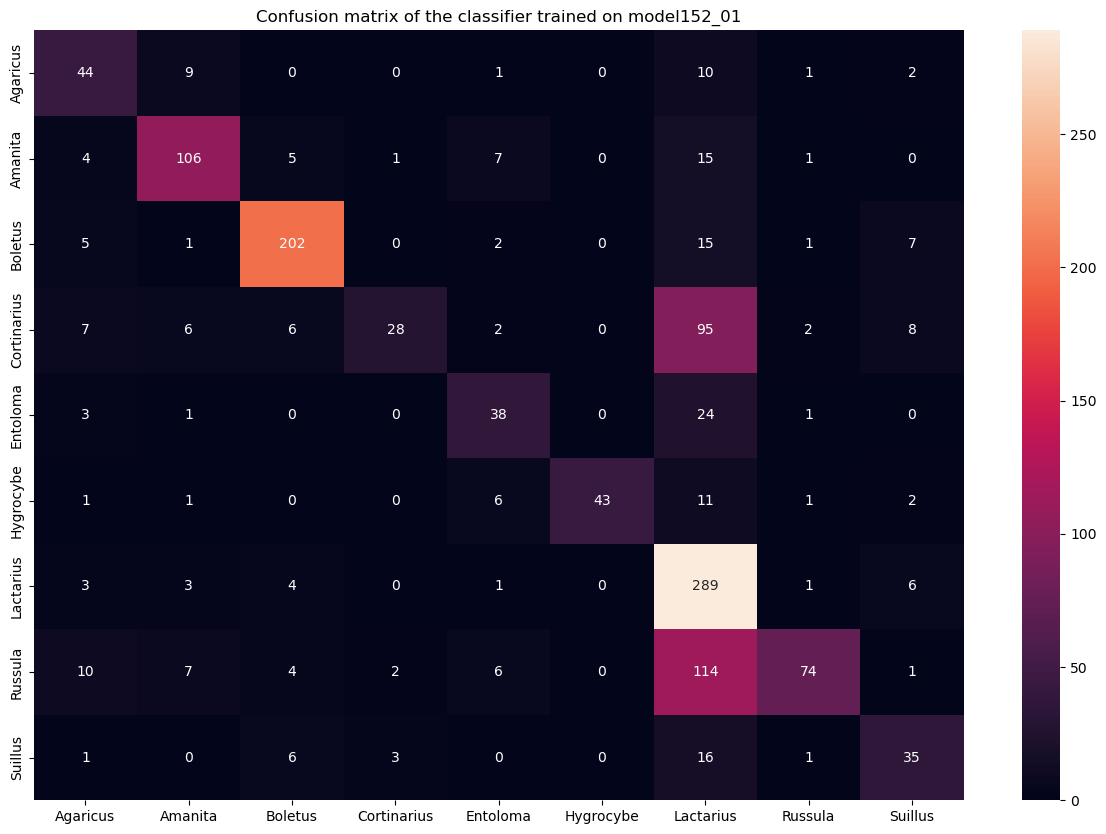

In [233]:
for conf_mat, model_name in zip(conf_mat_list, model_name_list):
    plot_confusion_matrix(conf_mat, (15, 10), model_name)

## Conclusions

## References

Mushrooms classification - Common genus's images. Kaggle, UPDATED 5 YEARS AGO, https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images